In [2]:
import torch
from pathlib import Path
import os, sys
# Add parent directory to Python path for imports
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

from runners import Runner
from utils import get_batch, load_shakespeare
from collections import defaultdict
from ipywidgets import interact
import ipywidgets as widgets
from scipy.spatial.distance import cdist

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device= torch.device("cpu")

# device = "cpu"
print(f"Using device: {device}")
%load_ext autoreload
%autoreload 2

Using device: mps


In [3]:
text, vocab_size, tokenizer, detokenizer = load_shakespeare("../shakespeare.txt")
print(tokenizer("Good day,\nmy name is verona,\nAnd I am a very good man,verily"))
print(detokenizer(tokenizer("Good day,\nmy name is verona,\nAnd I am a very good man,verily")))

[63, 161, 3, 2, 13, 191, 18, 2571, 3, 2, 6, 8, 85, 11, 162, 63, 88, 3, 4938]
good day,
 my name is Verona,
 and i am a very good man, verily


In [4]:
data = torch.tensor(tokenizer(text))
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]
block_size = 150
batch_size = 50

# Print an example of a training batch
x, y = get_batch(train_data, block_size, batch_size)

In [5]:
import torch
loaded_runner = Runner.load("../saved/shakespeare_transformer_model.pt", tokenizer=tokenizer, detokenizer=detokenizer)
generated_text = loaded_runner.generate("Well, if it be not so, I'll be the first to know it.\n", tokenizer = tokenizer, detokenizer=detokenizer, max_new_tokens=200)
print(generated_text)


 PLANTAGENET.
 ( have please all tear ) how may halt sign with many dogs, and UNK seeming to make slew, my UNK price. Rome elder my pleasure about sauce you with discharged sleeve of this disgrace, go is a hen is sorrow,
 CORIOLANUS.

 o letters, Margaret.

 ROSS halter
 territories upon it is, with thee reservation, i may hanging!

 third comes

 BASSANIO; then out Launcelet must bless with one curse and seldom expectation of messenger.
 lady? UNK like England ourselves, least: her reverend foolish more our heels, than it comforted to ’ ring home answered a change loins giving.
 for thee, i valiant? — lay Timon his sake wishes the Jew, Mowbray, the curtal foolish, though
 good tower rather malice here commodity. enter Richard of flung;
? do CORDELIA pages the parliament, in his day career are thy on.
 o fell most talks.

 BEDFORD.
 pardon mean? i ’ s sake


In [7]:
def forward_without_last_layer(net, x, include_pos_emb = False):
    """Forward pass through all but the last transformer block"""
    batch_size, seq_len = x.shape
    
    # Get embeddings
    tok_emb = net.token_embedding(x)
    pos_emb = net.position_embedding(torch.arange(seq_len)).unsqueeze(0)
    if include_pos_emb:
        x = tok_emb + pos_emb
    else:
        x = tok_emb
    
    # Pass through all but the last block
    for i in range(len(net.blocks) - 1):
        x = net.blocks[i](x)
    
    return x

In [8]:
from tqdm import tqdm


for _ in tqdm(range(100)):
    x, y = get_batch(train_data, loaded_runner.block_size, 100)
    embeddings = forward_without_last_layer(loaded_runner.net.to("cpu"), x)
    embeddings_flat = embeddings.view(-1, embeddings.shape[-1])

    # Calculate average embeddings for each token
    embedding_avg = defaultdict(lambda: torch.zeros(embeddings.shape[-1]))
    embedding_count = defaultdict(lambda: 0)
    x_flat = x.reshape(-1)
    embeddings_flat = embeddings.reshape(-1, embeddings.shape[-1])

    for token, emb in zip(x_flat, embeddings_flat):
        word = detokenizer([token.item()])
        embedding_avg[word] += emb
        embedding_count[word] += 1


# Compute final averages
embedding_avg = {word: emb / embedding_count[word] 
                for word, emb in embedding_avg.items()}


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


In [9]:
from sklearn.decomposition import PCA
import numpy as np

words = list(embedding_avg.keys())
X = torch.stack([embedding_avg[w] for w in words]).detach().numpy()
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)  # shape (num_words, 2)

/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/li

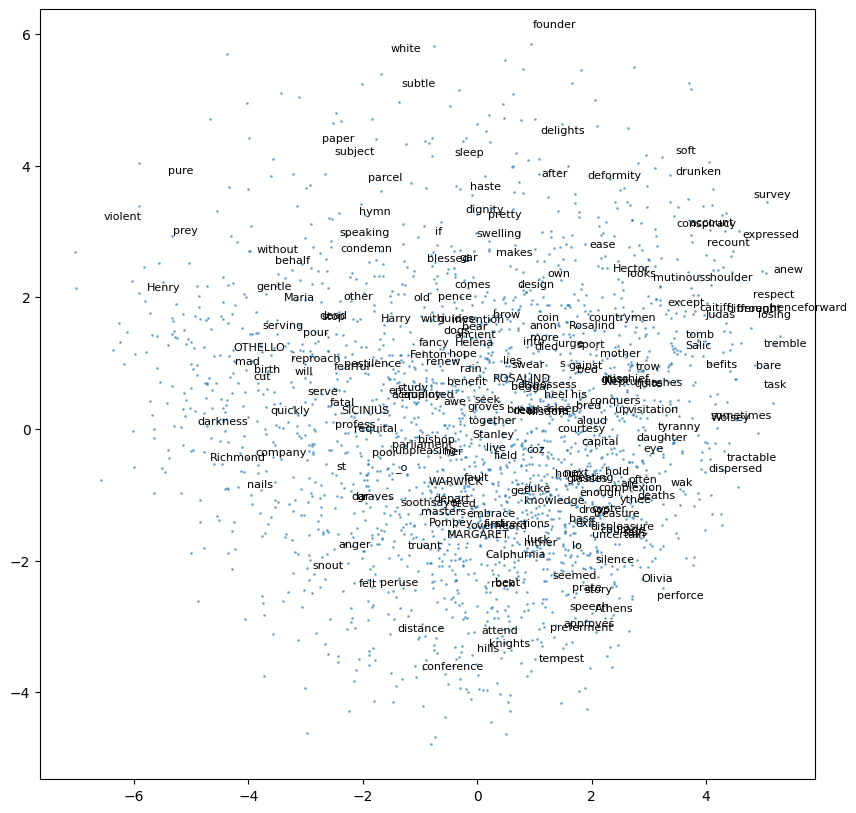

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(X_2d[:,0], X_2d[:,1], s=1, alpha=0.5)

# optionally annotate a few words
for i, word in enumerate(words):
    if i % 10 == 0:  # label every 50th to reduce clutter
        plt.text(X_2d[i,0]+0.5, X_2d[i,1]+0.5, word, fontsize=8)

plt.show()

In [11]:
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np

def find_nearest_words(x_coord = 0, y_coord = 0, X_2d=X_2d, words=words, n=5):
    point = np.array([[x_coord, y_coord]])
    distances = cdist(point, X_2d)[0]
    nearest_indices = np.argsort(distances)[:n]
    
    nearest_words = [words[i] for i in nearest_indices]
    nearest_distances = distances[nearest_indices]
    
    plt.figure(figsize=(10, 10))
    plt.scatter(X_2d[:,0], X_2d[:,1], s=1, alpha=0.5)
    plt.scatter([x_coord], [y_coord], c='red', marker='+', s=50)
    plt.scatter(X_2d[nearest_indices,0], X_2d[nearest_indices,1], c='red', s=5)

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    
    word_list = "\n".join([f"{w} ({d:.2f})" for w, d in zip(nearest_words, nearest_distances)])
    plt.annotate(word_list, 
                xy=(x_coord, y_coord),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round', fc='yellow', alpha=0.8))
    
    plt.show()
    return nearest_words, nearest_distances

x_min, x_max = float(X_2d[:,0].min()), float(X_2d[:,0].max())
y_min, y_max = float(X_2d[:,1].min()), float(X_2d[:,1].max())

x_slider = widgets.FloatSlider(
    value=float((x_max + x_min) / 2),
    min=x_min,
    max=x_max,
    step=(x_max - x_min) / 100,
    description='X:'
)

y_slider = widgets.FloatSlider(
    value=float((y_max + y_min) / 2),
    min=y_min,
    max=y_max,
    step=(y_max - y_min) / 100,
    description='Y:'
)

# interact(find_nearest_words, x_coord=x_slider, y_coord=y_slider)


/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jordanlei/Github/transformer-sandbox/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


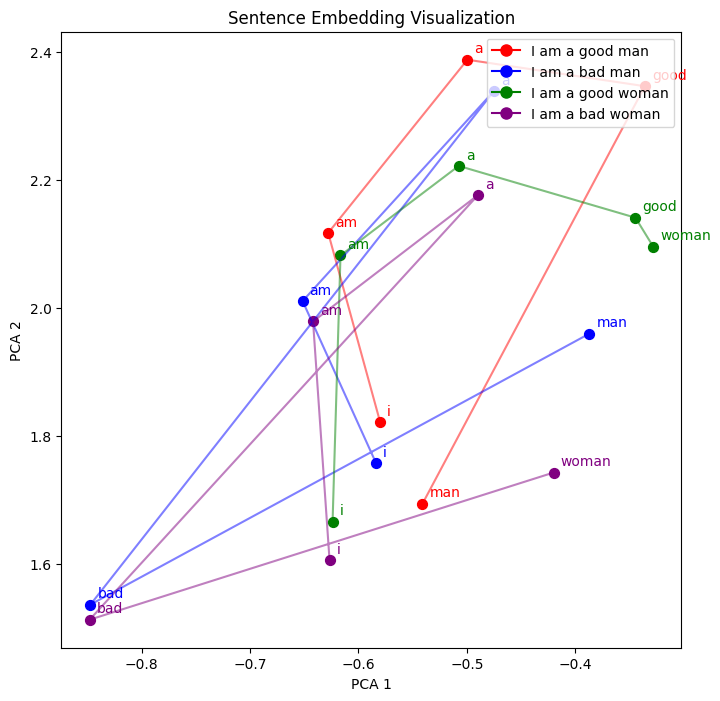

In [26]:
from ipywidgets import interact, widgets

def get_sentence_embeddings(sentence, tokenizer, block_size, model):
    """Get embeddings for a sentence."""
    tokens = tokenizer(sentence)
    
    # Pad or truncate tokens to match block size
    tokens = tokens[:block_size] if len(tokens) >= block_size else tokens + [0] * (block_size - len(tokens))
    
    # Get embeddings
    x = torch.tensor([tokens])
    with torch.no_grad():
        embeddings = forward_without_last_layer(model.to("cpu"), x)
    return tokens, embeddings

# Test sentences and colors for visualization
test_sentences = [
    "I am a good man", 
    "I am a bad man",
    "I am a good woman",
    "I am a bad woman",
]
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']

# Get embeddings for all sentences
all_tokens = []
all_embeddings = []
for sentence in test_sentences:
    tokens, embeddings = get_sentence_embeddings(sentence, tokenizer, block_size, loaded_runner.net)
    all_tokens.append(tokens)
    all_embeddings.append(embeddings)

# Project embeddings to 2D
combined_embeddings = torch.cat(all_embeddings).cpu().numpy().reshape(-1, 128)
embeddings_2d = pca.transform(combined_embeddings)

# Create visualization
fig, ax = plt.subplots(figsize=(8,8))

# Plot sentence paths
for sent_idx, (tokens, sentence) in enumerate(zip(all_tokens, test_sentences)):
    start_idx = sent_idx * block_size
    sent_embeddings = embeddings_2d[start_idx:start_idx + block_size]
    
    # Get valid token points (non-padding)
    valid_points = np.array([sent_embeddings[i] for i in range(block_size) if tokens[i] > 1])
    
    if len(valid_points) > 0:
        # Plot path and points
        ax.plot(valid_points[:,0], valid_points[:,1], 
                c=colors[sent_idx], alpha=0.5, linestyle='-')
        ax.scatter(valid_points[:,0], valid_points[:,1],
                  c=colors[sent_idx], s=50)
        
        # Add token labels
        for i, point in enumerate(valid_points):
            ax.annotate(detokenizer([tokens[i]]),
                       xy=(point[0], point[1]),
                       xytext=(5, 5),
                       textcoords='offset points', 
                       color=colors[sent_idx])

# Add labels and legend
ax.set_title('Sentence Embedding Visualization')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color=c, label=s, markersize=8)
                  for c, s in zip(colors, test_sentences)],
         loc='upper right')

plt.show()